In [1]:
from random import randint
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from scipy import (              
    misc, stats, ndimage)
from scipy.stats import linregress
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import (
    pairwise_tukeyhsd, MultiComparison)

For the data from the Mustard experiment (csv, rda), consider potentiel pairwise interaction effects of the explanatory variables medium (soil, cotton wool, newspaper, or sawdust), frequency of watering (1, 3, or 5 times over 14 days), and type of light (normal, red, or green) on the weight of the plants in grams.

In [2]:
df = pd.read_csv("Mustard.csv")
df.head()

,weight,light,watering,medium
0,2.02,normal,1,soil
1,0.30,normal,1,cottonwool
2,0.27,normal,1,newspaper
3,0.09,normal,1,sawdust
4,2.04,normal,1,soil


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    105 non-null    float64
 1   light     108 non-null    object 
 2   watering  108 non-null    int64  
 3   medium    108 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.5+ KB


In [6]:
df.dropna(subset = ["weight"], inplace=True)
df.dropna(subset = ["light"], inplace=True)
df.dropna(subset = ["watering"], inplace=True)
df.dropna(subset = ["medium"], inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 107
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   weight    105 non-null    float64
 1   light     105 non-null    object 
 2   watering  105 non-null    int64  
 3   medium    105 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 4.1+ KB


> Visualize the pairwise interaction effects.

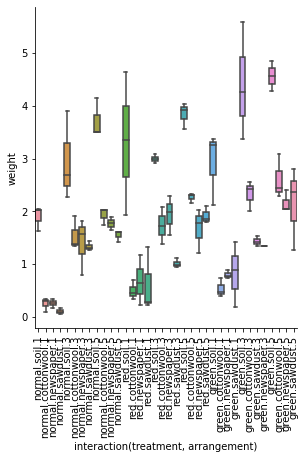

In [20]:
# Create interaction 
df["interaction"] = df.light.astype(str).str.cat(df.medium.astype(str), sep='.').str.cat(df.watering.astype(str), sep='.')


sns.catplot(x="interaction", y="weight", kind="box", data=df);
plt.xlabel("interaction(treatment, arrangement)")
plt.xticks(rotation=90);
plt.show()

> Statistically assess their significance using an analysis of variance.

In [22]:
import researchpy as rp
rp.summary_cat(df[["light", "medium", "watering"]])

,Variable,Outcome,Count,Percent
0,light,red,36,34.29
1,,normal,35,33.33
2,,green,34,32.38
3,medium,soil,27,25.71
4,,cottonwool,27,25.71
5,,sawdust,27,25.71
6,,newspaper,24,22.86
7,watering,1,36,34.29
8,,5,35,33.33
9,,3,34,32.38


In [23]:
from statsmodels.formula.api import ols

model = ols("weight ~ C(light, Sum) + C(medium, Sum) + C(watering, Sum) + C(light, Sum)*C(medium, Sum)*C(watering, Sum)", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,352.424935,1.0,1605.278498,1.614567e-49
"C(light, Sum)",6.195218,2.0,14.109460,7.292750e-06
"C(medium, Sum)",84.090658,3.0,127.676290,4.248457e-28
"C(watering, Sum)",38.812414,2.0,88.394332,9.245062e-20
"C(light, Sum):C(medium, Sum)",1.592081,6.0,1.208642,3.124360e-01
"C(light, Sum):C(watering, Sum)",1.246619,4.0,1.419572,2.366948e-01
"C(medium, Sum):C(watering, Sum)",1.741985,6.0,1.322443,2.590035e-01
"C(light, Sum):C(medium, Sum):C(watering, Sum)",3.294222,12.0,1.250419,2.681899e-01
Residual,15.148350,69.0,NaN,NaN


The interaction between light, medium, and watering is statistically non-significant. This indicates that different level combinations of the factors do not produce a significant difference in the weight. Thus this term should be removed from the ANOVA model and re-ran looking at the 2-factor interactions.

In [24]:
model = ols("weight ~ C(light, Sum) + C(medium, Sum) + C(watering, Sum) + C(light, Sum):C(medium, Sum) + C(light, Sum):C(watering, Sum) + C(medium, Sum):C(watering, Sum)", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,365.503743,1.0,1605.296864,3.627420e-55
"C(light, Sum)",7.199438,2.0,15.810010,1.596656e-06
"C(medium, Sum)",83.627589,3.0,122.431128,5.289502e-30
"C(watering, Sum)",39.285002,2.0,86.270101,8.506415e-21
"C(light, Sum):C(medium, Sum)",1.282499,6.0,0.938792,4.720616e-01
"C(light, Sum):C(watering, Sum)",1.378317,4.0,1.513396,2.060287e-01
"C(medium, Sum):C(watering, Sum)",1.964641,6.0,1.438121,2.103382e-01
Residual,18.442572,81.0,NaN,NaN


Same situation we can observe here. The interaction between two-pairs combinations is statistically non-significant. Thus this term should be removed from the ANOVA model and re-ran

In [25]:
model = ols("weight ~ C(light, Sum) + C(medium, Sum) + C(watering, Sum) + C(light, Sum)", data=df).fit()

aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,368.566929,1.0,1540.189523,2.483426e-61
"C(light, Sum)",7.230904,2.0,15.108466,1.940888e-06
"C(medium, Sum)",84.005218,3.0,117.015342,4.132096e-32
"C(watering, Sum)",39.333620,2.0,82.184842,1.322974e-21
Residual,23.212073,97.0,NaN,NaN


A study was designed to determine the optimal operating conditions to maximize weight. The study assessed different light, 4 types of medium, and watering. The overall interaction between the three factors was statistically non-significant, F(12, 69.0)= 1.25, p-value= 0.268. After looking at the reduced model the only significant interaction was medium and watering. The non-signifance interactions were removed and the final model showed that medium have a statistically significant interaction effect on weight, F(3, 97)=117.015, p-value= 4.1231e-32
